# Decoder and PHATE idea


In [2]:
import phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

In [3]:
# Load CSV files into a DataFrame
file1 = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
df_facs_decision1 = pd.read_csv(file1)

file2 ='/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision2.csv'
df_facs_decision2 = pd.read_csv(file2)

# Forcefully define valid timepoints
genes = df_facs_decision1.drop(df_facs_decision1.columns[[0,1,7,9,10]], axis=1) 


valid_timepoints_for_1 = [2.0, 2.5, 3.0, 3.5]
filtered_df = genes[genes['timepoint'].isin(valid_timepoints_for_1)]

cell_types_0 = filtered_df[filtered_df['cluster_post_replacement'].isin([0])]
cell_types_1 = filtered_df[filtered_df['cluster_post_replacement'].isin([1])]
cell_types_2 = filtered_df[filtered_df['cluster_post_replacement'].isin([2])]
cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'].isin([3])]

data = filtered_df.drop(filtered_df.columns[[ 5, 6, 7]], axis=1)
data = data[:6000]

In [4]:
phate_op = phate.PHATE(
    random_state=42,
    knn=4,           # slightly larger neighborhood to stabilize the graph
    decay=200,         # good balance of locality
    t='auto',    # high diffusion time for smooth trajectories
)


embedding_2D = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 6000 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.13 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.37 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.28 seconds.
  Calculated landmark operator in 3.95 seconds.
  Calculating optimal t...
    Automatically selected t = 34
  Calculated optimal t in 3.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.77 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.35 seconds.
Calculated PHATE in 10.38 seconds.


In [10]:
from scipy.sparse.linalg import eigs  # sparse and partial eigendecomposition

# Extract diffusion operator P
P = phate_op.diff_op

# Efficient power operation through matrix-vector multiplication
def matvec_power(v):
    x = v
    for _ in range(phate_op.t):
        x = P @ x
    return x

# Wrap in a linear operator to avoid explicit P^t
from scipy.sparse.linalg import LinearOperator

n = P.shape[0]
P_t_linop = LinearOperator((n, n), matvec=matvec_power, dtype=np.float64)

# Get top 3 eigenpairs of P^t (skip the trivial 1st)
eigvals, eigvecs = eigs(P_t_linop, k=3, which='LR')  # 'LR' = largest real part

# Sort and take real part
idx = np.argsort(-np.abs(eigvals))
eigvals = eigvals[idx].real
eigvecs = eigvecs[:, idx].real

# Create 2D embedding
embedding_2D = eigvecs[:, 1:3] * eigvals[1:3]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(embedding_2D[:, 0], embedding_2D[:, 1], s=10, alpha=0.8)
plt.title("Efficient 2D Diffusion Embedding from PHATE $P^t$")
plt.xlabel("Diffusion Component 1")
plt.ylabel("Diffusion Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: 'str' object cannot be interpreted as an integer

In [12]:
from pydiffmap import diffusion_map as dm


# Example: random 5D data
X = np.random.randn(1000, 5)

# Step 1: Create the Diffusion Map object
mydmap = dm.DiffusionMap.from_sklearn(n_evecs=3, epsilon='bgh', alpha=0.5)

# Step 2: Fit and transform
embedding = mydmap.fit_transform(data)

# Step 3: Plot the result
plt.figure(figsize=(6, 5))
plt.scatter(embedding[:, 1], embedding[:, 2], s=10)
plt.xlabel("Diffusion Coordinate 1")
plt.ylabel("Diffusion Coordinate 2")
plt.title("2D Diffusion Map Embedding")
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# --- Step 0: Assume these are already defined ---
# embedding_2D: (n_samples, 2) - your intrinsic manifold coords (from PHATE eigendecomposition)
# X: (n_samples, 5) - your high-dimensional data

# Simulate them here for demo purposes — replace with real values

# --- Step 1: Define decoder model: R^2 → R^5 ---
latent_input = layers.Input(shape=(2,))
x = layers.Dense(64, activation='relu')(latent_input)
x = layers.Dense(128, activation='relu')(x)
x_output = layers.Dense(5)(x)

decoder = Model(inputs=latent_input, outputs=x_output)

# --- Step 2: Define custom loss with distance preservation ---
def distance_preserving_loss(x_true, x_pred, z_batch, lambda_dist=1.0):
    # Reconstruction loss
    recon_loss = tf.reduce_mean(tf.square(x_true - x_pred))

    # Pairwise distances in latent and decoded spaces
    z_dist = tf.norm(tf.expand_dims(z_batch, axis=1) - tf.expand_dims(z_batch, axis=0), axis=-1)
    x_dist = tf.norm(tf.expand_dims(x_pred, axis=1) - tf.expand_dims(x_pred, axis=0), axis=-1)

    # Distance preservation loss
    dist_loss = tf.reduce_mean(tf.square(x_dist - z_dist))

    return recon_loss + lambda_dist * dist_loss

# --- Step 3: Custom training loop ---
optimizer = tf.keras.optimizers.Adam()
loss_history = []

z_tensor = tf.convert_to_tensor(embedding_2D, dtype=tf.float32)
x_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
for epoch in range(50):
    with tf.GradientTape() as tape:
        x_pred = decoder(z_tensor)
        loss = distance_preserving_loss(x_tensor, x_pred, z_tensor, lambda_dist=1.0)
    grads = tape.gradient(loss, decoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
    loss_history.append(loss.numpy())


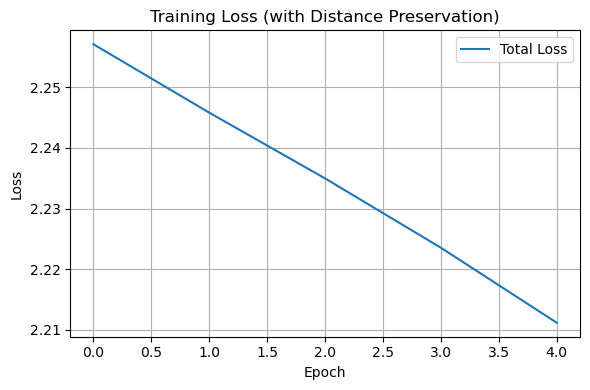

In [7]:

# --- Step 4: Plot training loss ---
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (with Distance Preservation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


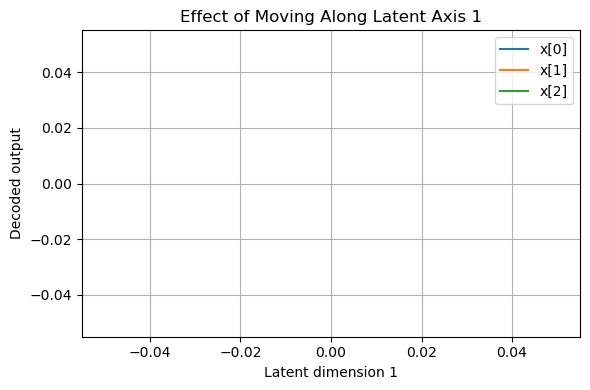

In [8]:
# --- Step 5: Plot decoded variation along latent axis 1 ---
z_grid = np.linspace(-3, 3, 100)
z_probe = np.stack([z_grid, np.zeros_like(z_grid)], axis=1)
decoded = decoder.predict(z_probe)

plt.figure(figsize=(6, 4))
for i in range(3):
    plt.plot(z_grid, decoded[:, i], label=f"x[{i}]")
plt.xlabel("Latent dimension 1")
plt.ylabel("Decoded output")
plt.title("Effect of Moving Along Latent Axis 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# --- Step 6: Jacobian at a single point ---
z_sample = tf.convert_to_tensor(embedding_2D[:1], dtype=tf.float32)  # first point
with tf.GradientTape() as tape:
    tape.watch(z_sample)
    x_decoded = decoder(z_sample)
jacobian = tape.batch_jacobian(x_decoded, z_sample)

print("Decoded 5D vector:", x_decoded.numpy())
print("Jacobian shape:", jacobian.shape)  # Should be (1, 5, 2)

Decoded 5D vector: [[nan nan nan nan nan]]
Jacobian shape: (1, 5, 2)
